In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from data_frame import getDataFrame
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from model_resnet9 import ResNet9
import torchvision
from skimage.morphology import skeletonize

/Users/terry/miniconda3/envs/torch-nightly/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/terry/miniconda3/envs/torch-nightly/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/terry/miniconda3/envs/torch-nightly/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: /Users/terry/miniconda3/envs/torch-nightly/lib/python3.8/site-packages/torchvision/image.so
  Reason: tried: '/Users/terry/miniconda3/envs/torch-nightly/lib/libpng16.16.dylib' (no such file), '/Users/terry/miniconda3/envs/torch-nightly/lib/libpng16.16.dylib' (no such file), '/Users/terry/miniconda3/envs/torch-nightly/lib/python3.8/lib-dynload/../../libpng16.16.dylib' (no such file), '/Users/terry/

In [2]:
train_df = getDataFrame()
train_df = train_df[:578]

In [10]:
BATCH = 8
EPOCHS = 10
LR = 0.002
IM_SIZE = 224

Transform = transforms.Compose(
    [
    transforms.ToTensor(),
    # transforms.CenterCrop(666),
    transforms.Resize((IM_SIZE, IM_SIZE))
    ])

alter_img = transforms.Compose([
    transforms.ToTensor(),
    # transforms.CenterCrop(666),
    transforms.RandomAffine(degrees=(0, 180), translate=(0.05, 0.1)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.Resize((IM_SIZE, IM_SIZE))
])

In [11]:
def split_indices(n, val_pct=0.25, seed=99):
    n_val = int(val_pct*n)
    np.random.seed(seed)
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]

In [12]:
X_Train, Y_Train = train_df['image_dir'].values, train_df['category'].values
train_indices, val_indices = split_indices(len(X_Train))

class GetData(Dataset):
    def __init__(self, FNames, Labels, Transform):
        self.fnames = FNames
        self.transform = Transform
        self.labels = Labels         
        
    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, index):       
        # x = Image.open(self.fnames[index])
        img = cv2.imread(self.fnames[index])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Edge detection with sobel filters
        blur = cv2.GaussianBlur(gray, (3,3), 0)
        edge = cv2.Sobel(blur, cv2.CV_64F, 1, 1, ksize=5)
        mask = cv2.inRange(edge, (-1000000), (0))
        edge[mask>0] = 0
        mask2 = cv2.inRange(edge,(255), (1000000))
        edge[mask2>0] = 255
        edge = edge.astype(np.uint8)
        
        kernel = np.ones((5,5), np.uint8)
        img_dilation = cv2.dilate(edge, kernel, iterations=1)
        biedge = img_dilation.astype(float)/255
        biedge = biedge.astype(np.uint8)  
        skel = skeletonize(biedge)
        skel = (skel*255).astype(np.uint8)
        
        x = cv2.merge((edge,edge,edge))
        if "train" in self.fnames[index]:             
            return self.transform(x), self.labels[index]
        elif "test" in self.fnames[index]:            
            return self.transform(x), self.fnames[index]
                
trainset1 = GetData(X_Train[train_indices], Y_Train[train_indices], Transform)
trainset2 = GetData(X_Train[train_indices], Y_Train[train_indices], alter_img)
trainset3 = GetData(X_Train[train_indices], Y_Train[train_indices], alter_img)
trainset4 = GetData(X_Train[train_indices], Y_Train[train_indices], alter_img)

trainset = trainset1 + trainset2 + trainset3 + trainset4
valset = GetData(X_Train[val_indices], Y_Train[val_indices], Transform)

print(len(trainset) + len(valset))

1880


In [13]:
train_dl = DataLoader(trainset, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(valset, batch_size=BATCH, shuffle=True)

images.shape: torch.Size([8, 3, 224, 224])
tensor([6, 3, 4, 5, 0, 8, 0, 6])


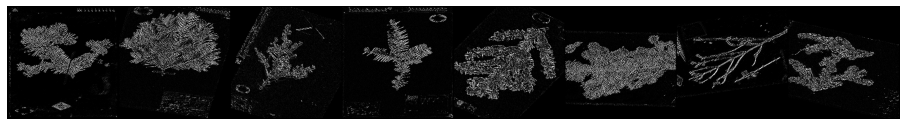

In [19]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    print(labels)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

In [20]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

device

device(type='mps')

In [23]:
model = torchvision.models.densenet169(pretrained=True)
N_Classes = train_df['category'].nunique()

# for param in model.parameters():
#     param.requires_grad = False
    
n_inputs = model.classifier.in_features
last_layer = nn.Linear(n_inputs, N_Classes)
model.classifier = last_layer

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

/Users/terry/miniconda3/envs/torch-nightly/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/terry/miniconda3/envs/torch-nightly/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

from tqdm import tqdm

def train(trainloader, model, criterion, optimizer, scaler, device=torch.device(device)):
    train_acc = 0.0
    train_loss = 0.0
    model.train()
    for images, labels in tqdm(train_dl):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=True):
            output = model(images)
            loss = criterion(output, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        acc = ((output.argmax(dim=1) == labels).float().mean())
        train_acc += acc
        train_loss += loss
        del output
        del loss
    return train_acc/len(trainloader), train_loss/len(trainloader)

def evaluate(testloader, model, criterion, device=torch.device(device)):
    eval_acc = 0.0
    eval_loss = 0.0
    model.eval()
    for images, labels in tqdm(val_dl):
        images = images.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            output = model(images)
            loss = criterion(output, labels)

        acc = ((output.argmax(dim=1) == labels).float().mean())
        eval_acc += acc
        eval_loss += loss
        del output
        del loss
  
    return eval_acc/len(testloader), eval_loss/len(testloader)

In [26]:
%%time
##%dirsrmal Training
scaler = torch.cuda.amp.GradScaler(enabled=True)
for epoch in range(EPOCHS):
    train_acc, train_loss = train(train_dl, model, criterion, optimizer, scaler, device=device)
    torch.save(model, './edge_dense.pth')
    eval_acc, eval_loss = evaluate(val_dl, model, criterion, device=device)
    print("")
    print(f"Epoch {epoch + 1} | Train Acc: {train_acc*100} | Train Loss: {train_loss}")
    print(f"\t Val Acc: {eval_acc*100} | Val Loss: {eval_loss}")
    print("===="*8)

  0%|          | 0/217 [00:01<?, ?it/s]


KeyboardInterrupt: 

torch.Size([13, 3, 224, 224])

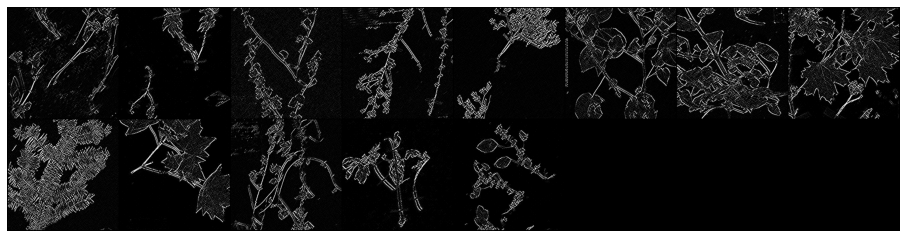

In [56]:
for images, labels in val_dl:
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        output = model(images)
    break

images = images[output.argmax(dim=1) != labels].cpu()

plt.figure(figsize=(16,8))
plt.axis('off')
plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
images.shape